Before you turn this lab in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
DRIVER = "Carles"
NAVIGATOR = "Jonathan"

# Autoencoder Lab

Welcome to the autoencoder lab! By the end of this lab you will have

- Created and tuned an autoencoder in Keras

*The code in the lab was based on [this blogpost](https://blog.keras.io/building-autoencoders-in-keras.html)*.

# Auto-Grader Variables

In [2]:
ENCODING_DIM = 32

def passed(): print('✅')

# Load MNIST

The following code loads MNIST and normalizes it and flattens it.

In [3]:
from IPython.display import display
from keras.datasets import mnist
from keras.preprocessing.image import array_to_img
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%pylab inline
[X_train, _], [X_test, _] = mnist.load_data()
X_train = np.array([x.flatten() for x in X_train.astype('float32')/255.])
X_test = np.array([x.flatten() for x in X_test.astype('float32')/255.])

for x in X_train[:5]:
    img = array_to_img(x.reshape(28, 28, 1))
    display(img)

Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


# Task

- Define an encoder which maps a flattened MNIST image to a vector of size `ENCODING_DIM`

# Requirements

- Use a keras sequential model
- Do not compile your model!

In [4]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.regularizers import l1

ENCODING_DIM = 32

encoder = Sequential(name='encoder')
encoder.add(Dense(units=ENCODING_DIM, activity_regularizer=l1(1e-5), input_shape=[784] ))
#encoder.add(Dense(units=ENCODING_DIM, activity_regularizer=l1(1e-5), input_shape=[784] ))


encoder.summary()
#SVG(model_to_dot(encoder).create(prog='dot', format='svg'))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                25120     
Total params: 25,120.0
Trainable params: 25,120
Non-trainable params: 0.0
_________________________________________________________________


# Encoder Tests

In [5]:
import keras

assert type(encoder) == keras.models.Sequential
assert encoder.input_shape == (None, 784)
assert encoder.output_shape == (None, ENCODING_DIM)
assert not hasattr(encoder, 'optimizer')
encoder.predict(X_train[:1])

passed()

✅


# Task

- Define a decoder which maps a compressed version of an image back to a flattened image

# Requirements

- Use a keras sequential model
- Do not compile your model!

In [6]:
decoder = Sequential(name='decoder')

decoder.add(Dense(units=64, activation='relu', input_shape=[ENCODING_DIM]))
decoder.add(Dense(units=128, activation='relu'))
decoder.add(Dense(units=784, activation='sigmoid'))

decoder.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_3 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_4 (Dense)              (None, 784)               101136    
Total params: 111,568.0
Trainable params: 111,568
Non-trainable params: 0.0
_________________________________________________________________


# Decoder Tests

In [7]:
import keras

assert type(decoder) == keras.models.Sequential
assert decoder.input_shape == (None, ENCODING_DIM)
assert decoder.output_shape == (None, 784)
assert not hasattr(encoder, 'optimizer')
decoder.predict(encoder.predict(X_train[:1]))

passed()

✅


# Task

- Define an autoencoder by hooking together `encoder` and `decoder` via the keras functional API

# Requirements

- Compile the model with a binary crossentropy loss on a per-pixel basis

In [8]:
from keras.models import Model
from keras.layers import Input

In [9]:
input_ = Input(shape=[784])
hidden = encoder(input_)
decode = decoder(hidden)

autoencoder = Model(inputs=input_,outputs=decode)


In [10]:
autoencoder.compile(optimizer='adam',loss='binary_crossentropy')

# Autoencoder Tests

In [11]:
import numpy as np

assert type(autoencoder) == keras.engine.training.Model
assert autoencoder.input_shape == encoder.input_shape
assert autoencoder.output_shape == decoder.output_shape
assert hasattr(autoencoder, 'optimizer')
X = X_train[:1]
X_encoded = encoder.predict(X)
assert np.all(decoder.predict(X_encoded) == autoencoder.predict(X))
assert len(autoencoder.layers) == 3
assert type(autoencoder.layers[1]) == keras.models.Sequential
assert type(autoencoder.layers[2]) == keras.models.Sequential
assert type(autoencoder.layers[0]) == keras.engine.topology.InputLayer

passed()

✅


# Task

- Optimize your autoencoder on the training data

In [12]:
autoencoder.fit(X_train,X_train)

Epoch 1/1
60000/60000 [==============================] - 12s - loss: 0.1381      

In [13]:
X_encoded = encoder.predict(X_test)
X_reconstructed = decoder.predict(X_encoded)

# Task

- Visualize the performance of your autoencoder

# Requirements

- Convert each image in `X_test` to a `PIL` image and save it into a python list called `test_imgs`
- Run each image in `X_test` through your autoencoder then convert it back into a `PIL` image and save it into a python list called `reconstructed_imgs`

In [14]:
from IPython.display import Image

In [15]:
test_imgs = [array_to_img(x.reshape(28, 28, 1)) for x in X_test]
reconstructed_imgs = [array_to_img(x.reshape(28, 28, 1)) for x in X_reconstructed]


In [16]:
idxs = np.random.choice(len(X_test), size=5)
for idx in idxs:
    real_img, reconstructed_img = test_imgs[idx], reconstructed_imgs[idx]
    print( ' real image ')
    display(real_img)
    print('fake image')
    display(reconstructed_img)

 real image 


fake image


 real image 


fake image


 real image 


fake image


 real image 


fake image


 real image 


fake image


# Autoencoder Visualization Tests

In [17]:
import PIL

assert len(test_imgs) == len(X_test)
for test_img, reconstructed_img in zip(test_imgs, reconstructed_imgs):
    assert type(test_img) == PIL.Image.Image
    assert type(reconstructed_img) == PIL.Image.Image
    assert test_img.size == (28, 28)
    assert reconstructed_img.size == (28, 28)
    
passed()

✅


# Challenge Activities

- Add a sparsity constraint to the encoder
- Make the encoder deeper
- Make the decoder deeper
- Add noise to your data samples

In [18]:
noise_factor = .4

In [19]:
X_train_noisy = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape) 
X_test_noisy = X_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape) 
X_train_noisy = np.clip(X_train_noisy, 0., 1.)
X_test_noisy = np.clip(X_test_noisy, 0., 1.)

In [20]:
display(array_to_img(X_train_noisy[0].reshape(28,28,1)))

In [21]:
display(array_to_img(X_train_noisy[1].reshape(28,28,1)))

In [22]:
#### Create a new autoencoder with noisy images
ENCODING_DIM = 32

encoder_noisy = Sequential(name='encoder')
encoder_noisy.add(Dense(units=ENCODING_DIM, activity_regularizer=l1(1e-5), input_shape=[784] ))
encoder_noisy.add(Dense(units=ENCODING_DIM, activity_regularizer=l1(1e-5)))
#encoder.add(Dense(units=ENCODING_DIM, activity_regularizer=l1(1e-5), input_shape=[784] ))


encoder_noisy.summary()
#SVG(model_to_dot(en

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 32)                25120     
_________________________________________________________________
dense_6 (Dense)              (None, 32)                1056      
Total params: 26,176.0
Trainable params: 26,176
Non-trainable params: 0.0
_________________________________________________________________


In [23]:
decoder_noisy = Sequential(name='decoder')

decoder_noisy.add(Dense(units=64, activation='relu', input_shape=[ENCODING_DIM]))
decoder_noisy.add(Dense(units=128, activation='relu'))
decoder_noisy.add(Dense(units=256, activation='relu'))
decoder_noisy.add(Dense(units=784, activation='sigmoid'))

decoder_noisy.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_8 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_9 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_10 (Dense)             (None, 784)               201488    
Total params: 244,944.0
Trainable params: 244,944
Non-trainable params: 0.0
_________________________________________________________________


In [24]:
input_ = Input(shape=[784])
hidden_noisy = encoder_noisy(input_)
decode_noisy = decoder(hidden_noisy)

autoencoder_noisy = Model(inputs=input_,outputs=decode_noisy)


In [25]:
autoencoder_noisy.compile(optimizer='adam',loss='binary_crossentropy')

In [35]:

history = autoencoder_noisy.fit(X_train_noisy,X_train,epochs=5, validation_data=(X_test_noisy,X_test_noisy))

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 14s - loss: 0.1084 - val_loss: 1.4849

In [36]:
autoencoder_noisy.evaluate(X_test_noisy,X_test_noisy)

 9600/10000 [===========================>..] - ETA: 0s

1.520135478591919

In [37]:
history.params

{'batch_size': 32,
 'do_validation': True,
 'epochs': 5,
 'metrics': ['loss', 'val_loss'],
 'samples': 60000,
 'verbose': 1}

In [48]:
history.params['metrics']

['loss', 'val_loss']

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


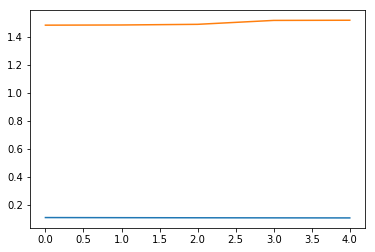

In [56]:
plt.plot(pd.DataFrame(history.history))
plt.legend()

In [59]:
x_test_nosisy_predict = autoencoder_noisy.predict(X_test_noisy)

In [62]:
print('Original noisy data')
[display(array_to_img(X_test_noisy[i].reshape(28,28,1))) for i in range(10)]

Original noisy data


[None, None, None, None, None, None, None, None, None, None]

In [60]:
print('AUtoencoder trained on noisy data')
[display(array_to_img(x_test_nosisy_predict[i].reshape(28,28,1))) for i in range(10)]

AUtoencoder trained on noisy data


[None, None, None, None, None, None, None, None, None, None]